<a href="https://colab.research.google.com/github/aksha1510/lab/blob/main/IVA_assignment_4_21mia1086.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import os

def load_video(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Could not open video file: {video_path}")

    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)

    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.release()

    return frames, fps

In [ ]:
def segment_frame(frame):
    # Simple color thresholding (adjust thresholds as needed)
    lower = np.array([0, 0, 0])
    upper = np.array([50, 50, 50])
    mask = cv2.inRange(frame, lower, upper)
    return mask

In [ ]:
def track_objects_contours(prev_mask, curr_mask):
    # Simple object tracking using contour matching
    prev_contours, _ = cv2.findContours(prev_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    curr_contours, _ = cv2.findContours(curr_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Match contours based on area and position (simplified)
    matched_contours = []
    for prev_cnt in prev_contours:
        for curr_cnt in curr_contours:
            if cv2.matchShapes(prev_cnt, curr_cnt, 1, 0.0) < 0.1:
                matched_contours.append(curr_cnt)
                break

    return matched_contours

In [ ]:
def spatio_temporal_segmentation(frames):
    segmented_frames = []
    prev_mask = None

    for frame in frames:
        mask = segment_frame(frame)

        if prev_mask is not None:
            matched_objects = track_objects_contours(prev_mask, mask)
            # Draw matched objects on the frame
            cv2.drawContours(frame, matched_objects, -1, (0, 255, 0), 2)

        segmented_frames.append(frame)
        prev_mask = mask

    return segmented_frames

In [ ]:
def identify_foreground_background(edge_frames):
    background_mask = np.zeros_like(edge_frames[0])
    foreground_masks = []

    for edge_frame in edge_frames:
        # Treat each edge frame as a foreground mask
        foreground_masks.append(edge_frame)
        # Accumulate edges to create a background mask
        background_mask = cv2.bitwise_or(background_mask, edge_frame)

    return foreground_masks, background_mask

In [ ]:
def detect_scene_cuts(frames, threshold=30):
    scene_cuts = []
    prev_hist = None

    for i, frame in enumerate(frames):
        curr_hist = cv2.calcHist([frame], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        curr_hist = cv2.normalize(curr_hist, curr_hist).flatten()

        if prev_hist is not None:
            diff = cv2.compareHist(prev_hist, curr_hist, cv2.HISTCMP_CHISQR)
            if diff > threshold:
                scene_cuts.append(i)

        prev_hist = curr_hist

    return scene_cuts

In [ ]:
def perform_edge_detection(frames):
    edge_frames = []
    for frame in frames:
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray_frame, 100, 200)
        edge_frames.append(edges)
    return edge_frames

In [ ]:
def track_objects(edge_frames):
    object_tracks = []
    for i in range(len(edge_frames) - 1):
        prev_edges = edge_frames[i]
        curr_edges = edge_frames[i + 1]
        contours, _ = cv2.findContours(prev_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        current_track = []
        for contour in contours:
            if cv2.contourArea(contour) > 500:  # minimum area to consider as an object
                x, y, w, h = cv2.boundingRect(contour)
                current_track.append((x, y, w, h))
        object_tracks.append(current_track)
    return object_tracks

In [ ]:
def visualize_results(frames, segmented_frames, scene_cuts):
    output_dir = "output_frames"
    os.makedirs(output_dir, exist_ok=True)

    for i in scene_cuts:
        scene_cut_frame = frames[i]
        segmented_frame = segmented_frames[i]

        # Save scene cut frame
        cv2.imwrite(os.path.join(output_dir, f"scene_cut_frame_{i}.jpg"), scene_cut_frame)

        # Save segmented frame
        cv2.imwrite(os.path.join(output_dir, f"segmented_frame_{i}.jpg"), segmented_frame)

        # Display frames (comment out if running on a server without display)
        cv2.imshow(f"Scene Cut at Frame {i}", scene_cut_frame)
        cv2.imshow(f"Segmented Frame {i}", segmented_frame)
        cv2.waitKey(1000)  # Wait for 1 second between frames

    cv2.destroyAllWindows()


In [ ]:
def display_saved_images(output_dir):
    scene_cut_images = sorted([f for f in os.listdir(output_dir) if f.startswith("scene_cut_frame")])
    segmented_images = sorted([f for f in os.listdir(output_dir) if f.startswith("segmented_frame")])

    n_images = min(len(scene_cut_images), len(segmented_images))

    fig, axes = plt.subplots(n_images, 2, figsize=(12, 4*n_images))
    fig.suptitle("Scene Cuts and Segmented Frames", fontsize=16)

    for i in range(n_images):
        scene_cut_img = cv2.imread(os.path.join(output_dir, scene_cut_images[i]))
        scene_cut_img = cv2.cvtColor(scene_cut_img, cv2.COLOR_BGR2RGB)
        segmented_img = cv2.imread(os.path.join(output_dir, segmented_images[i]))
        segmented_img = cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB)

        axes[i, 0].imshow(scene_cut_img)
        axes[i, 0].set_title(f"Scene Cut Frame {i}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(segmented_img)
        axes[i, 1].set_title(f"Segmented Frame {i}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def mse(imageA, imageB):
    # Compute the Mean Squared Error between two images
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

def calculate_scene_cut_similarity(output_dir):
    # Get all scene cut image files
    scene_cut_images = sorted([f for f in os.listdir(output_dir) if f.startswith("scene_cut_frame")])

    similarity_scores = []
    for i in range(len(scene_cut_images) - 1):
        imgA = cv2.imread(os.path.join(output_dir, scene_cut_images[i]))
        imgB = cv2.imread(os.path.join(output_dir, scene_cut_images[i+1]))

        # Ensure images are the same size
        if imgA.shape != imgB.shape:
            imgB = cv2.resize(imgB, (imgA.shape[1], imgA.shape[0]))

        # Calculate similarity
        similarity = mse(imgA, imgB)
        similarity_scores.append(similarity)
        print(f"Similarity between scene cuts {i} and {i+1}: {similarity}")

    return similarity_scores

Processed 453 frames
Tracked objects across 452 frame pairs
Generated 453 foreground masks
Background mask shape: (360, 640)
Completed spatio-temporal segmentation
Detected 12 scene cuts at frames: [50, 81, 88, 109, 136, 160, 161, 173, 186, 246, 282, 311]
Results visualization completed. Check the 'output_frames' directory for saved images.
Similarity between scene cuts 0 and 1: 336.00957465277776
Similarity between scene cuts 1 and 2: 277.79516493055553
Similarity between scene cuts 2 and 3: 2882.798394097222
Similarity between scene cuts 3 and 4: 31869.734244791667
Similarity between scene cuts 4 and 5: 30662.621866319445
Similarity between scene cuts 5 and 6: 24311.351809895834
Similarity between scene cuts 6 and 7: 42291.74493489583
Similarity between scene cuts 7 and 8: 13400.9589453125
Similarity between scene cuts 8 and 9: 44490.11302517361
Similarity between scene cuts 9 and 10: 22101.67931423611
Similarity between scene cuts 10 and 11: 3031.1858159722224
Similarity scores betw

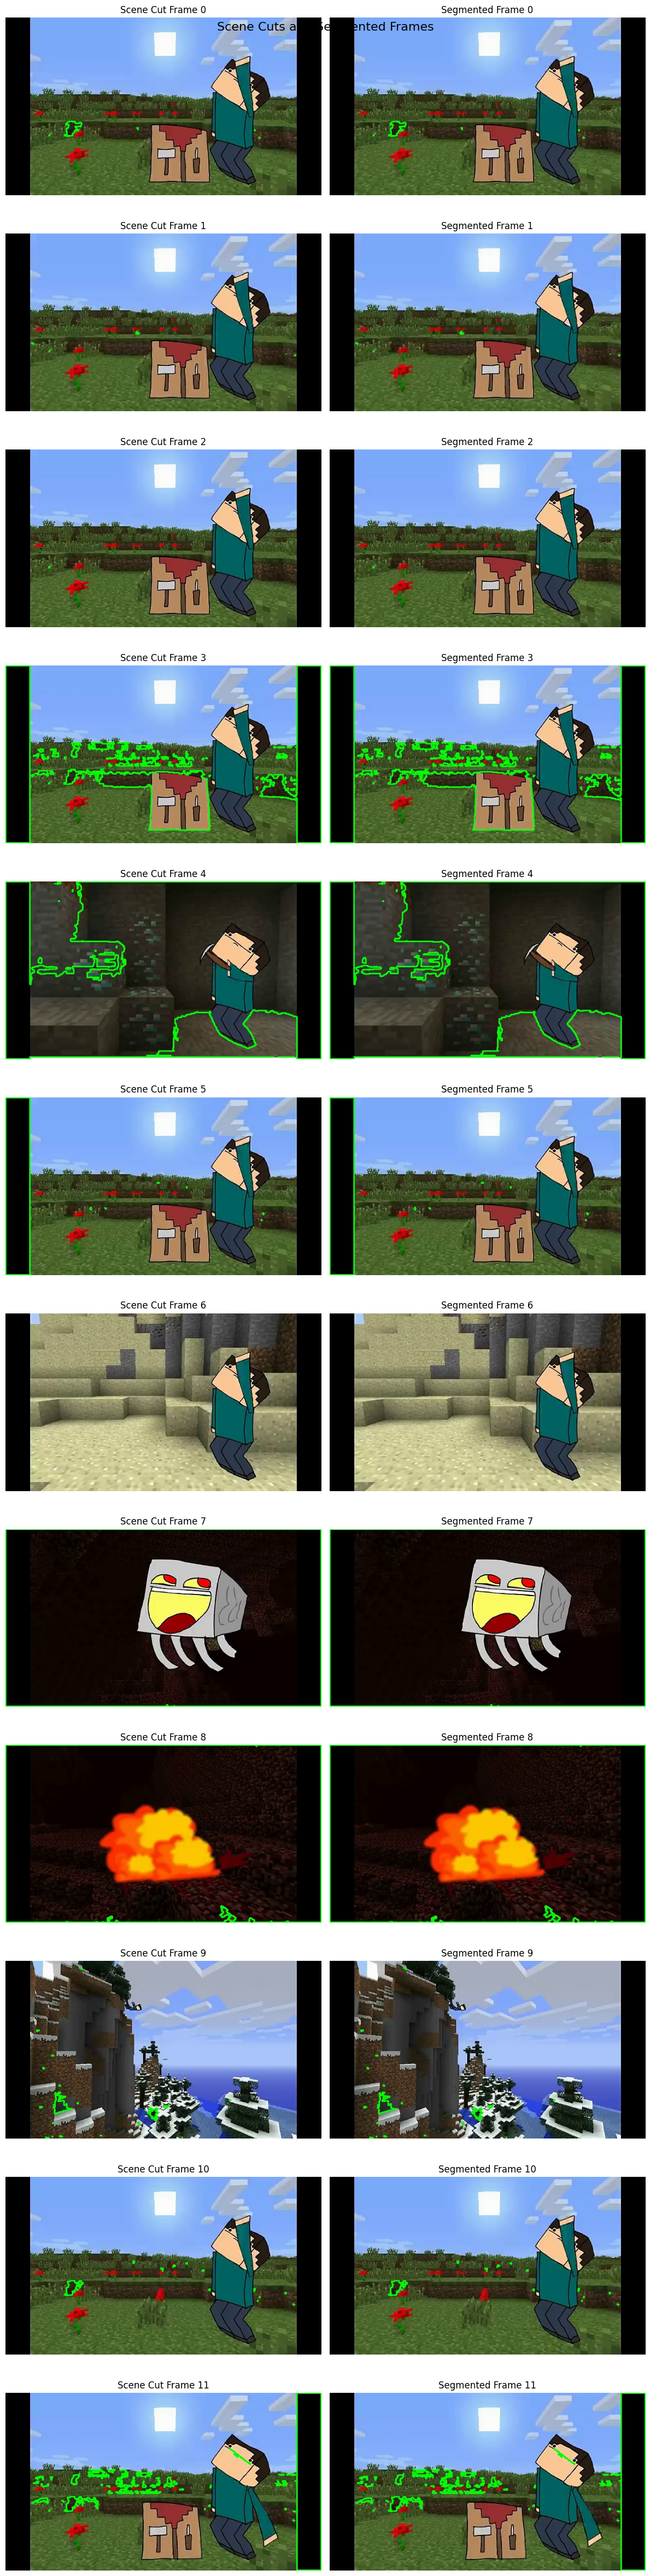

In [ ]:
import matplotlib.pyplot as plt

def process_video(video_path):
    # Load video frames
    frames, fps = load_video(video_path)

    # Perform edge detection segmentation
    edge_frames = perform_edge_detection(frames)

    # Track objects across frames
    object_tracks = track_objects(edge_frames)

    # Identify foreground and background
    foreground_masks, background_mask = identify_foreground_background(edge_frames)

    return frames, edge_frames, object_tracks, foreground_masks, background_mask

def main():
    video_file = "C:/Users/ASUS/Downloads/Minecraft in 15 seconds.mp4"

    # Process video
    frames, edge_frames, object_tracks, foreground_masks, background_mask = process_video(video_file)
    print(f"Processed {len(frames)} frames")
    print(f"Tracked objects across {len(object_tracks)} frame pairs")
    print(f"Generated {len(foreground_masks)} foreground masks")
    print(f"Background mask shape: {background_mask.shape}")

    # Perform spatio-temporal segmentation
    segmented_frames = spatio_temporal_segmentation(frames)
    print("Completed spatio-temporal segmentation")

    # Detect scene cuts
    scene_cuts = detect_scene_cuts(frames)
    print(f"Detected {len(scene_cuts)} scene cuts at frames: {scene_cuts}")

    # Visualize results
    visualize_results(frames, segmented_frames, scene_cuts)
    print("Results visualization completed. Check the 'output_frames' directory for saved images.")

    output_dir = "output_frames"
    similarity_scores = calculate_scene_cut_similarity(output_dir)
    print(f"Similarity scores between scene cuts: {similarity_scores}")

    # Display saved images
    display_saved_images("output_frames")

if __name__ == "__main__":
    main()